Human Suspicious Activity Detection Using LRCN Model

Dataset Loading:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Define the path to dataset folder
dataset_path = '/content/drive/My Drive/dataset'

# List the contents to verify the structure
for folder_name in os.listdir(dataset_path):
    print(f'Folder: {folder_name}')
    folder_path = os.path.join(dataset_path, folder_name)
    for video_file in os.listdir(folder_path):
        print(f'    File: {video_file}')


Folder: fight
    File: fi014.mp4
    File: fi056.mp4
    File: fi038.mp4
    File: fi061.mp4
    File: fi013.mp4
    File: fi037.mp4
    File: fi048.mp4
    File: fi001.mp4
    File: fi006.mp4
    File: fi002.mp4
    File: fi019.mp4
    File: fi023.mp4
    File: fi051.mp4
    File: fi030.mp4
    File: fi028.mp4
    File: fi024.mp4
    File: fi062.mp4
    File: fi045.mp4
    File: fi057.mp4
    File: fi034.mp4
    File: fi059.mp4
    File: fi008.mp4
    File: fi027.mp4
    File: fi017.mp4
    File: fi040.mp4
    File: fi011.mp4
    File: fi036.mp4
    File: fi025.mp4
    File: fi052.mp4
    File: fi009.mp4
    File: fi012.mp4
    File: fi031.mp4
    File: fi054.mp4
    File: fi010.mp4
    File: fi016.mp4
    File: fi050.mp4
    File: fi047.mp4
    File: fi029.mp4
    File: fi063.mp4
    File: fi044.mp4
    File: fi053.mp4
    File: fi004.mp4
    File: fi039.mp4
    File: fi049.mp4
    File: fi003.mp4
    File: fi026.mp4
    File: fi032.mp4
    File: fi007.mp4
    File: fi020.mp4
    Fi

Import Necessary Libraries:

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


Select Randomness:

In [ ]:
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)



View The Dataset Interms Of Frames With Intervals Of 10

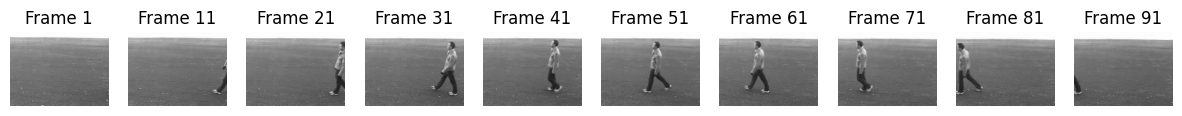

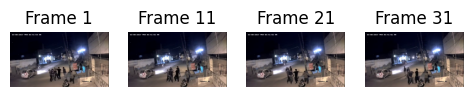

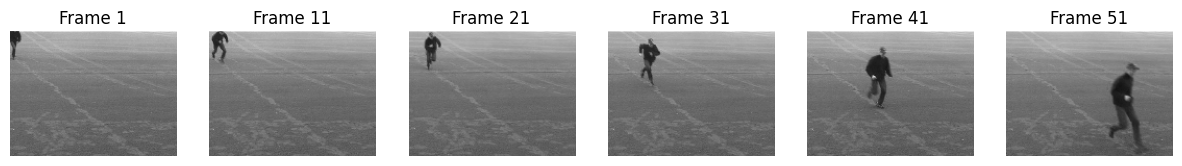

In [ ]:
def view_frames_at_intervals(video_path, interval=10, num_frames_to_display=10):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return

    frames = []
    count = 0
    frame_number = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_number % interval == 0 and count < num_frames_to_display:
            frames.append(frame)
            count += 1
        frame_number += 1

    cap.release()

    if len(frames) == 0:
        print("No frames to display.")
        return

    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(frames):
        plt.subplot(1, num_frames_to_display, i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Frame {i*interval + 1}")
    plt.show()

# View frames at regular intervals
view_frames_at_intervals('/content/drive/MyDrive/dataset/walking/person22_walking_d1_uncomp.avi', interval=10, num_frames_to_display=10)

view_frames_at_intervals('/content/drive/MyDrive/dataset/fight/fi085.mp4', interval=10, num_frames_to_display=10)

view_frames_at_intervals('/content/drive/MyDrive/dataset/running/person23_running_d2_uncomp.avi', interval=10, num_frames_to_display=6)




Set Dataset Variables:

In [ ]:
# Define paths to datasets
fight_path = '/content/drive/MyDrive/dataset/fight/'
running_path = '/content/drive/MyDrive/dataset/running/'
walking_path = '/content/drive/MyDrive/dataset/walking/'

# Define frame size and other variables
frame_size = (224, 224)
batch_size = 4



Extract Frames & Normalization Process, Data Preprocessing:

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define constants
SEQUENCE_LENGTH = 20  # Set to the desired sequence length
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
DATASET_DIR = '/content/drive/MyDrive/dataset'  # Update to dataset path
CLASSES_LIST = ['fight', 'running', 'walking']  # List of classes

def frames_extraction(video_path):
    '''
    Extracts frames from a video, resizes, and normalizes them.
    Args:
        video_path: The path of the video file.
    Returns:
        frames_list: List of resized and normalized frames.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

def create_dataset():
    '''
    Extracts frames from videos and prepares dataset.
    Returns:
        features: List of video frames.
        labels: List of class indexes.
        video_files_paths: List of video file paths.
    '''
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting data for class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Train Test Split:

In [ ]:
import os
import cv2
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define constants
SEQUENCE_LENGTH = 20  # Set to the desired sequence length
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 8  # Set the batch size
DATASET_DIR = '/content/drive/MyDrive/dataset'  # Update to the dataset path
CLASSES_LIST = ['fight', 'running', 'walking']  # List of classes

def frames_extraction(video_path):
    '''
    Extracts frames from a video, resizes, and normalizes them.
    Args:
        video_path: The path of the video file.
    Returns:
        frames_list: List of resized and normalized frames.
    '''
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

def video_data_generator(video_files, labels, batch_size):
    '''
    Generator to yield batches of video frames and labels.
    Args:
        video_files: List of video file paths.
        labels: List of labels corresponding to the video files.
        batch_size: Number of samples per batch.
    Yields:
        batch_features: Batch of video frames.
        batch_labels: Batch of labels.
    '''
    num_samples = len(video_files)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_video_files = video_files[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]

            batch_features = []
            for video_file in batch_video_files:
                frames = frames_extraction(video_file)
                if len(frames) == SEQUENCE_LENGTH:
                    batch_features.append(frames)

            batch_features = np.asarray(batch_features)
            batch_labels = to_categorical(batch_labels, num_classes=len(CLASSES_LIST))
            yield batch_features, batch_labels

def load_dataset():
    '''
    Loads the dataset and splits it into training and testing sets.
    Returns:
        train_videos: List of training video file paths.
        test_videos: List of testing video file paths.
        train_labels: List of training labels.
        test_labels: List of testing labels.
    '''
    video_files = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            video_files.append(video_file_path)
            labels.append(class_index)

    return train_test_split(video_files, labels, test_size=0.25, random_state=42, shuffle=True)

# Load dataset and split into training and testing sets
train_videos, test_videos, train_labels, test_labels = load_dataset()

# Create data generators for training and testing
train_generator = video_data_generator(train_videos, train_labels, BATCH_SIZE)
test_generator = video_data_generator(test_videos, test_labels, BATCH_SIZE)

# Number of steps per epoch
steps_per_epoch = len(train_videos) // BATCH_SIZE
validation_steps = len(test_videos) // BATCH_SIZE


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LRCN Model Creation :

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.utils import plot_model

def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: The constructed LRCN model.
    '''

    #  use of a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the model's summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

# Create the model
model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 224, 224, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 56, 56, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 56, 56, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 14, 14, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 14, 14, 128)   7

View Model Architecture:

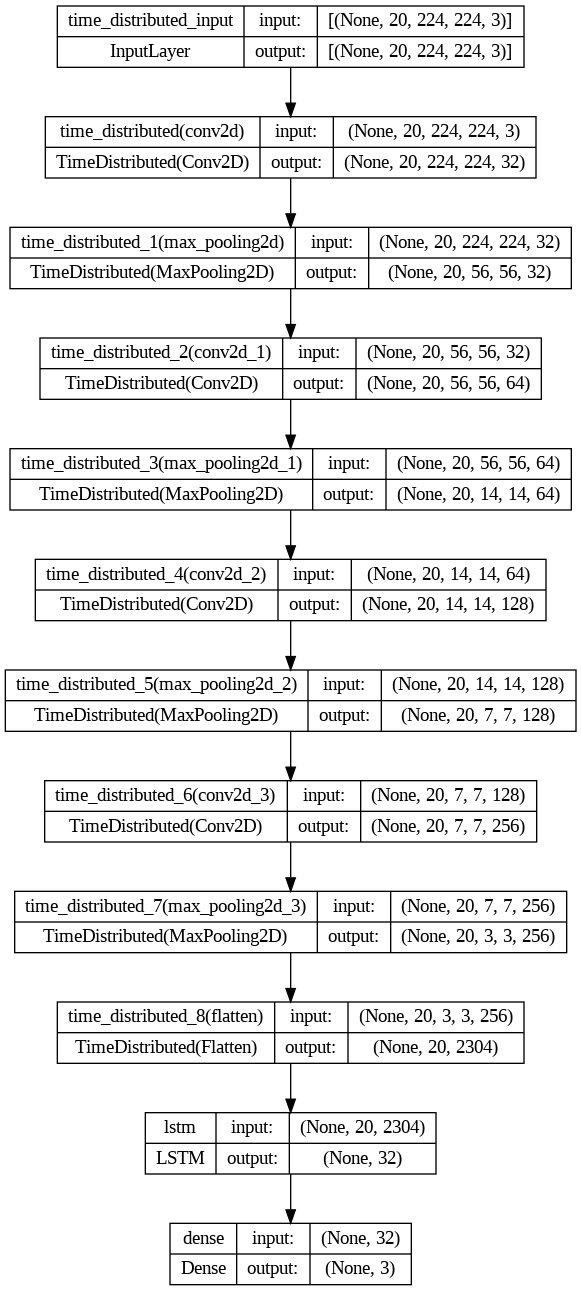

In [ ]:
# Visualize the model architecture
plot_model(model, to_file='lrcn_model.png', show_shapes=True, show_layer_names=True)

Model Training:

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Create an instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

# Compile the model and specify loss function, optimizer, and metrics.
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Start training the model using the data generator.
model_training_history = model.fit(
    train_generator,
    epochs=70,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping_callback]
)


Epoch 1/70
28/28 [==============================] - 450s 16s/step - loss: 0.7455 - accuracy: 0.6071 - val_loss: 0.4956 - val_accuracy: 0.6528
Epoch 2/70
28/28 [==============================] - 391s 14s/step - loss: 0.8355 - accuracy: 0.6221 - val_loss: 0.5749 - val_accuracy: 0.6806
Epoch 3/70
28/28 [==============================] - 396s 14s/step - loss: 0.5579 - accuracy: 0.6820 - val_loss: 0.4888 - val_accuracy: 0.7015
Epoch 4/70
28/28 [==============================] - 386s 14s/step - loss: 0.6034 - accuracy: 0.6452 - val_loss: 1.2009 - val_accuracy: 0.3731
Epoch 5/70
28/28 [==============================] - 390s 14s/step - loss: 0.5813 - accuracy: 0.6912 - val_loss: 0.4783 - val_accuracy: 0.7463
Epoch 6/70
28/28 [==============================] - 391s 14s/step - loss: 0.5768 - accuracy: 0.6636 - val_loss: 0.4627 - val_accuracy: 0.7164
Epoch 7/70
28/28 [==============================] - 384s 14s/step - loss: 0.5159 - accuracy: 0.6912 - val_loss: 0.5072 - val_accuracy: 0.6716
Epoch 

Accuracy & Loss Graph While Training:

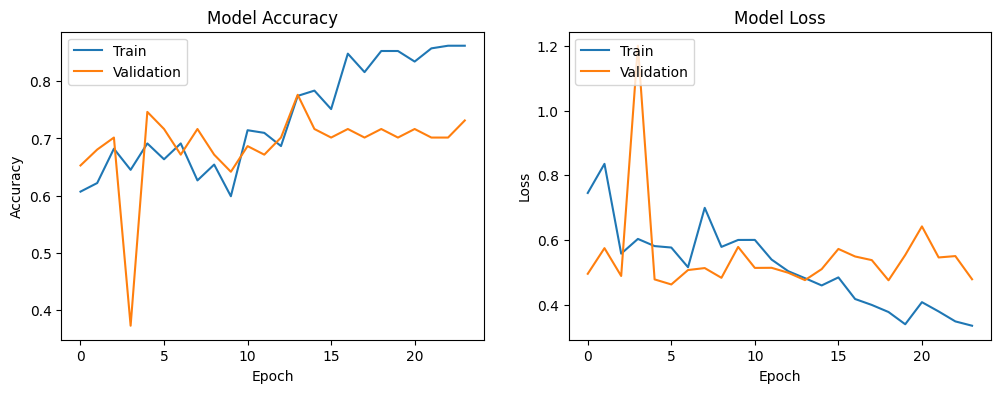

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_training_history.history['accuracy'])
plt.plot(model_training_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_training_history.history['loss'])
plt.plot(model_training_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Model Accuracy:

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=validation_steps)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


9/9 [==============================] - 64s 8s/step - loss: 0.4761 - accuracy: 0.7761
Test Accuracy: 77.61%
Test Loss: 0.4761


In [ ]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())


Current Working Directory: /content


Save The Model In Current Colab Environment:

In [ ]:
# Save the model to a specific path in the current Colab environment
model.save('/content/LRCN_model.h5')


In [ ]:
from tensorflow.keras.models import save_model

# Define the path where to save the model
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'

In [ ]:
import os

# Verify if the file exists
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'
if os.path.isfile(model_path):
    print("Model file exists.")
else:
    print("Model file does not exist.")



Model file exists.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# List all files in the directory to verify path
directory = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/'
files = os.listdir(directory)
print("Files in directory:", files)


Files in directory: ['LRCN_model.h5', '.ipynb_checkpoints']


Load The Trained Model :

In [ ]:
from tensorflow.keras.models import load_model

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'  # Adjust the path accordingly
model = load_model(model_path)


In [ ]:
from tensorflow.keras.models import load_model

# Attempt to load the model
try:
    model = load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")


Model loaded successfully!


In [ ]:
import os

model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'
if os.path.isfile(model_path):
    print(f"File size: {os.path.getsize(model_path)} bytes")
else:
    print("Model file does not exist.")


File size: 6352768 bytes


In [ ]:
!cp /content/LRCN_model.h5 /content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/


In [ ]:
import os

# Path to the re-saved model file
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'

if os.path.isfile(model_path):
    print(f"File found: {model_path}")
    print(f"File size: {os.path.getsize(model_path)} bytes")
else:
    print("Model file does not exist or path is incorrect.")


File found: /content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5
File size: 6352768 bytes


Check Whether It's Actually Detect Suspicious Or Normal Activity With New Video:

1. Successfully Detect A Walking Video As A Normal Activity

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Constants
SEQUENCE_LENGTH = 20
FRAME_SIZE = (224, 224)

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'
model = load_model(model_path)

def preprocess_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, FRAME_SIZE)  # Resize frames to match model input
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames extracted from the video.")

    # If not enough frames, pad with the last frame
    while len(frames) < SEQUENCE_LENGTH:
        frames.append(frames[-1])

    # Truncate frames if there are more than SEQUENCE_LENGTH
    frames = frames[:SEQUENCE_LENGTH]

    frames = np.array(frames)
    frames = frames.astype('float32') / 255.0  # Normalize
    return frames

def predict_video_class(video_path, model):
    frames = preprocess_video(video_path)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(frames)
    predicted_class = np.argmax(predictions, axis=1)
    # Map predicted class index to label
    if predicted_class == 0:
        return "Suspicious"
    else:
        return "Normal"

# Example usage
video_path = '/content/drive/MyDrive/dataset/walking/person25_walking_d2_uncomp.avi'
result = predict_video_class(video_path, model)
print(f"The video is classified as: {result}")



1/1 [==============================] - 1s 1s/step
The video is classified as: Normal


2. Successfully Detect A Fighting Video As A Suspicious Activity

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Constants
SEQUENCE_LENGTH = 20
FRAME_SIZE = (224, 224)

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'
model = load_model(model_path)

def preprocess_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, FRAME_SIZE)  # Resize frames to match model input
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames extracted from the video.")

    # If not enough frames, pad with the last frame
    while len(frames) < SEQUENCE_LENGTH:
        frames.append(frames[-1])

    # Truncate frames if there are more than SEQUENCE_LENGTH
    frames = frames[:SEQUENCE_LENGTH]

    frames = np.array(frames)
    frames = frames.astype('float32') / 255.0  # Normalize
    return frames

def predict_video_class(video_path, model):
    frames = preprocess_video(video_path)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(frames)
    predicted_class = np.argmax(predictions, axis=1)
    # Map predicted class index to label
    if predicted_class == 0:
        return "Suspicious"
    else:
        return "Normal"

# Example usage
video_path = '/content/drive/MyDrive/dataset/fight/fi095.mp4'
result = predict_video_class(video_path, model)
print(f"The video is classified as: {result}")


1/1 [==============================] - 1s 894ms/step
The video is classified as: Suspicious


3. Successfully Detect A Fighting Video As A Suspicious Activity

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Constants
SEQUENCE_LENGTH = 20
FRAME_SIZE = (224, 224)

# Load the model from Google Drive
model_path = '/content/drive/MyDrive/Human_Suspicious_Activity_Detection_Using_LRCN/LRCN_model.h5'
model = load_model(model_path)

def preprocess_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, FRAME_SIZE)  # Resize frames to match model input
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        raise ValueError("No frames extracted from the video.")

    # If not enough frames, pad with the last frame
    while len(frames) < SEQUENCE_LENGTH:
        frames.append(frames[-1])

    # Truncate frames if there are more than SEQUENCE_LENGTH
    frames = frames[:SEQUENCE_LENGTH]

    frames = np.array(frames)
    frames = frames.astype('float32') / 255.0  # Normalize if required
    return frames

def predict_video_class(video_path, model):
    frames = preprocess_video(video_path)
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension
    predictions = model.predict(frames)
    predicted_class = np.argmax(predictions, axis=1)
    # Map predicted class index to label
    if predicted_class == 0:
        return "Suspicious"
    else:
        return "Normal"

# Example usage
video_path = '/content/drive/MyDrive/dataset/fight/fi088.mp4'
result = predict_video_class(video_path, model)
print(f"The video is classified as: {result}")

1/1 [==============================] - 1s 879ms/step
The video is classified as: Suspicious



Thus Model Ensure It's Efficiency To Detect Human Activity As Suspicious Or Not

